In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.coordinates import CartesianRepresentation, UnitSphericalRepresentation
from astropy.coordinates.matrix_utilities import rotation_matrix, matrix_product

In [2]:
from scipy.integrate import quad 

def limb_darkening(u_ld, r):
    u1, u2 = u_ld
    mu = np.sqrt(1 - r**2)
    return (1 - u1 * (1 - mu) - u2 * (1 - mu)**2) / (1 - u1/3 - u2/6) / np.pi

def limb_darkening_normed(u_ld, r): 
    return limb_darkening(u_ld, r)/limb_darkening(u_ld, 0)

def total_flux(u_ld): 
    return 2 * np.pi * quad(lambda r: r * limb_darkening_normed(u_ld, r), 0, 1)[0]

spot_contrast = 0.7
u_ld = [0.5079, 0.2239]
f0 = total_flux(u_ld)

In [3]:
n_rotations = 30
angles = np.arange(0, 2*np.pi, 2*np.pi/n_rotations) * u.rad

In [109]:
inc_stellar = 30 * u.deg

spot_radii = np.array([0.2, 0.2, 0.1])
spot_lats = np.array([0, 80, 20])*u.deg
spot_lons = np.array([0, 180, 180])*u.deg
# spot_radii = np.array([0.2])
# spot_lats = np.array([60])*u.deg
# spot_lons = np.array([180])*u.deg

def lightcurve(spot_lons, spot_lats, spot_radii):
    usr = UnitSphericalRepresentation(spot_lons * np.ones((n_rotations, 1)), 
                                      spot_lats * np.ones((n_rotations, 1))) 
    cartesian = usr.represent_as(CartesianRepresentation)
    rotate = rotation_matrix(angles[:, np.newaxis], axis='z')
    tilt = rotation_matrix(-(90*u.deg - inc_stellar), axis='y')
    rotated_spot_positions = cartesian.transform(rotate)
    tilted_spot_positions = rotated_spot_positions.transform(tilt)

    r = np.ma.masked_array(np.sqrt(tilted_spot_positions.y**2 + tilted_spot_positions.z**2), 
                           mask=tilted_spot_positions.x < 0)
    ld = limb_darkening_normed(u_ld, r)

    f_spots = np.pi * spot_radii**2 * (1 - spot_contrast) * ld * np.sqrt(1 - r**2)

    delta_f = (1 - np.sum(f_spots/f0, axis=-1)).data
    return delta_f

In [110]:
delta_f = lightcurve(spot_lons, spot_lats, spot_radii)

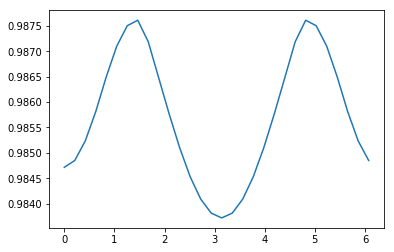

In [111]:
plt.plot(angles, delta_f)

In [112]:
from rms import Star, Planet, Spot, STSP
from astropy.time import Time

planet = Planet.non_transiting()
planet.t0 = 0

spots = []
for i in range(len(spot_lats)):
    spots.append(Spot(spot_lats[i], spot_lons[i], r_spot[i]))
    
star = Star(planet=planet, rotation_period=2*np.pi, inc_stellar=inc_stellar.to(u.degree).value, u=u_ld)

with STSP(Time(angles.value, format='jd'), star, spots) as s: 
    lc = s.generate_lightcurve()

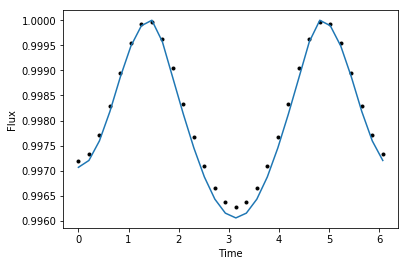

In [113]:
lc.plot(show=False)
plt.plot(angles, delta_f/delta_f.max())